<a href="https://colab.research.google.com/github/monarkparekh/MAE-598__Design-Optimization/blob/Assignment-5/MAE_598__Design_Optimization_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1><center>MAE 598 Design Optimization: 
Assignment 5</center></h1></b>

<h3><center>Name: Monark Parekh <br>
ASU ID: 1222179426</center></h3>

# <h2><b>Please choose one of the following problems.</b><h2>

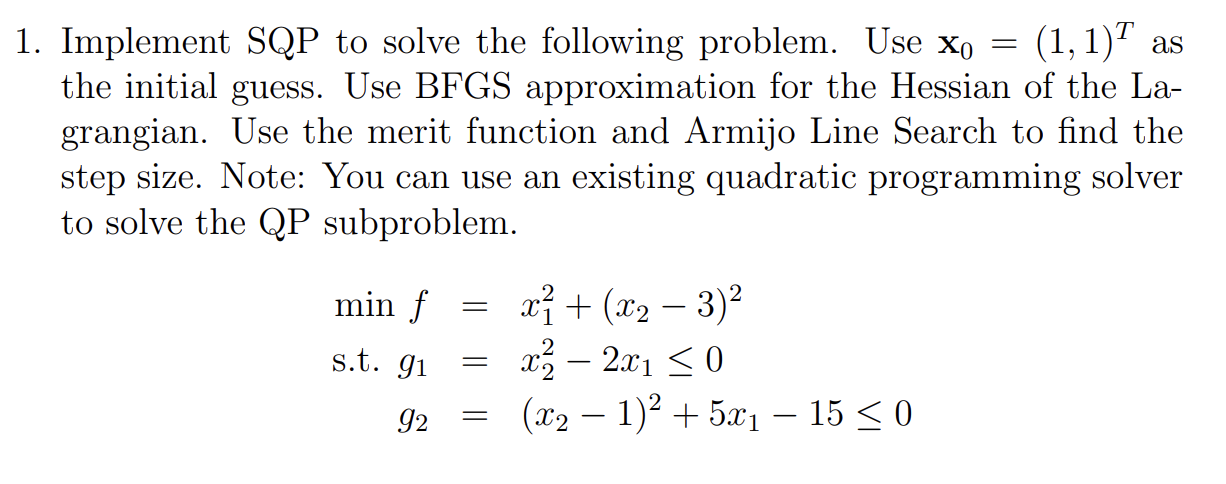

<h3><b>Importing Necessary Libraries</b></h3>

In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

<h3><b>Defining the Objective Function and the Inequality Constraints</b></h3>

In [2]:
objective_function = lambda x: x[0] ** 2 + (x[1] - 3) ** 2
constraint_g1 = lambda x: x[1] ** 2 - 2 * x[0]
constraint_g2 = lambda x: (x[1] - 1) ** 2 + 5 * x[0] - 15
gradient_objective_function  = lambda x : torch.tensor([[2 * x[0], 2 * (x[1] - 3)]])
gradient_constraint_g1 = lambda x : torch.tensor([[-2, 2 * x[1]]])
gradient_constraint_g2 = lambda x: torch.tensor([[5, 2 * (x[1] - 1)]])

<h3><b>Defining the Necessary Functions</b></h3>

In [3]:
def F_alpha(x,weights,alpha,s):
  constraint_1=max(0, constraint_g1(x + alpha * s)) # constrain 1
  constraint_2=max(0, constraint_g2(x + alpha * s)) # constrain 2
  return objective_function(x + alpha * s) + weights[0, :] * constraint_1 + weights[1, :] * constraint_2

In [4]:
def weights_of_merit_function(Lambda, weights, k):
  if k > 0:
    weights = torch.max(abs(Lambda), 0.5 *(weights + abs(Lambda)))
  else:
    weights = abs(Lambda)
  return weights

<h3><b>Defining the Line-Search Method</b></h3>

In [5]:
def lineSearch(x,Lambda,weights,s,k):
    t = 0.3
    alpha = 1
    weights = weights_of_merit_function(Lambda, weights, k)
    if constraint_g1(x) <= 0:
       dg1_da = 0
    else:
      dg1_da= torch.matmul(gradient_constraint_g1(x), s)

    if constraint_g2(x) <= 0:
       dg2_da = 0
    else:
      dg2_da= torch.matmul(gradient_constraint_g2(x), s)

    dF_da = torch.matmul(gradient_objective_function(x), s) + (weights[0, :] * dg1_da + weights[1, :] * dg2_da)

    phi = lambda x, weights, alpha, t, dF_da: F_alpha(x, weights, 0, 0) + alpha * t * dF_da

    while phi(x, weights, alpha, t, dF_da) < F_alpha(x, weights, alpha, s):
        alpha = 0.5 * alpha
    return alpha, weights

<h3><b>Defining the BFGS Method</b></h3>

In [6]:
def BFGS(x, W, s, Lambda, alpha):
    Lx_k = gradient_objective_function(x) + torch.matmul(Lambda.T, torch.tensor([constraint_g1(x), constraint_g2(x)]))
    Lx_kplus1 = gradient_objective_function(x + alpha * s) + torch.matmul(Lambda.T, torch.tensor([constraint_g1(x + alpha * s), constraint_g2(x + alpha * s)]))

    delta_l = Lx_kplus1 - Lx_k

    Q = torch.matmul(torch.matmul((alpha * s).T, W), (alpha * s))
    if torch.matmul((alpha * s).T, delta_l.T) >= 0.2 * torch.matmul(torch.matmul((alpha * s).T, W), (alpha * s)):
        theta = 1
    else:
        theta = 0.8 * Q / (Q - torch.matmul((alpha * s).T, delta_l.T))
    temp = theta * delta_l.T + (1 - theta) * torch.matmul(W, (alpha * s))
    W = W + torch.matmul(temp, temp.T) / torch.matmul(temp.T, s) - torch.matmul(torch.matmul(W, s),
                                                                       torch.matmul(s.T, W)) / torch.matmul(
        torch.matmul(s.T, W), s)
    return W

In [7]:
def Checker(Lambda, active):
    checked_lambda = 0
    if len(Lambda) == 0 or min(Lambda) > 0:
        checked_lambda  = 1
    else:
        Lambda_idx = np.argmin(np.array(Lambda))
        Lambda = Lambda[Lambda!=min(Lambda)]
        active.pop(Lambda_idx)
    return active, checked_lambda ,Lambda

<h3><b>Defining the QP Problem Solver</b></h3>

In [8]:
def QP_Solver(x, W):
    active = []
    initial_A = torch.cat((gradient_constraint_g1(x), gradient_constraint_g2(x)), 0)
    initial_B = torch.tensor([[constraint_g1(x), constraint_g2(x)]]).T
    initial_Lambda = torch.zeros((initial_B.shape[0], 1))
    Lambda = []
    while True:
        if len(active) == 0:
            s_Lambda = torch.matmul(torch.linalg.inv(W), -gradient_objective_function(x).T)
            s = s_Lambda[:2, :]
        if len(active) > 0:
            if len(active) == 1:
                A = initial_A[active[0], :].reshape(1, -1)
                B = initial_B[active[0], :].reshape(1, 1)
            if len(active) == 2:
                A = initial_A
                B = initial_B

            Z = torch.zeros((A.shape[0], A.shape[0]))
            matrix = torch.cat((torch.cat((W, A.T), 1), torch.cat((A, Z), 1)), 0)
            j = torch.cat((-gradient_objective_function(x).T, -B), 0)
            s_Lambda = torch.matmul(torch.linalg.inv(matrix), j)
            s = s_Lambda[:2, :]
            Lambda = s_Lambda[2:, :]

        if len(Lambda) == 1:
            initial_Lambda[0] = s_Lambda[2:3, :]
        if len(Lambda) == 2:
            initial_Lambda[0] = s_Lambda[2:3, :]
            initial_Lambda[1] = s_Lambda[3:, :]

        sqp_constraint = torch.round((torch.matmul(initial_A, s.reshape(-1, 1)) + initial_B))
        active, mu_check, Lambda = Checker(Lambda, active)

        if torch.max(sqp_constraint) <= 0 and mu_check == 1:
            return s, initial_Lambda
        else:
            index = np.argmax(sqp_constraint)
            active.append(index)
            active = np.unique(np.array(active)).tolist()

<h3><b>SQP Algorithm</b></h3>

In [9]:
x = torch.tensor([[1,1.]]).T
x_initial = x
Lambda = torch.zeros((x.shape[0], 1))
weights = torch.zeros((x.shape[0], 1))+2
W = torch.eye(x.shape[0])
eps = 1e-4
k = 0

delta_L_norm = np.linalg.norm(gradient_objective_function(x) + np.matmul(Lambda.T, torch.cat((gradient_constraint_g1(x), gradient_constraint_g2(x)), 0)))

while delta_L_norm > eps:
    s, Lambda = QP_Solver(x, W)
    a, weights = lineSearch(x,Lambda,weights,s,k)
    weights_old = weights
    W = BFGS(x,W, s, Lambda, a)
    x += a*s
    k += 1
    delta_L_norm = np.linalg.norm(gradient_objective_function(x) + np.matmul(Lambda.T, torch.cat((gradient_constraint_g1(x), gradient_constraint_g2(x)), 0)))


<h3><b>Results</b></h3>

In [10]:
print('The solution for the given question is: X = ({}, {})'.format(x[0][0], x[1][0]))

The solution for the given question is: X = (1.0602166652679443, 1.4561707973480225)


In [11]:
print('The Minimum Value of the Objective Function for the given problem is {}'.format(objective_function([x[0][0], x[1][0]])))
print("The Inequality Constraints at minimum value are:\nConstraint_g1={}\nConstraint_g2={}".format(constraint_g1([x[0][0], x[1][0]]), constraint_g2([x[0][0], x[1][0]])))

The Minimum Value of the Objective Function for the given problem is 3.507467746734619
The Inequality Constraints at minimum value are:
Constraint_g1=0.0
Constraint_g2=-9.490824699401855


<h3><b>Plotting the Results</b></h3>

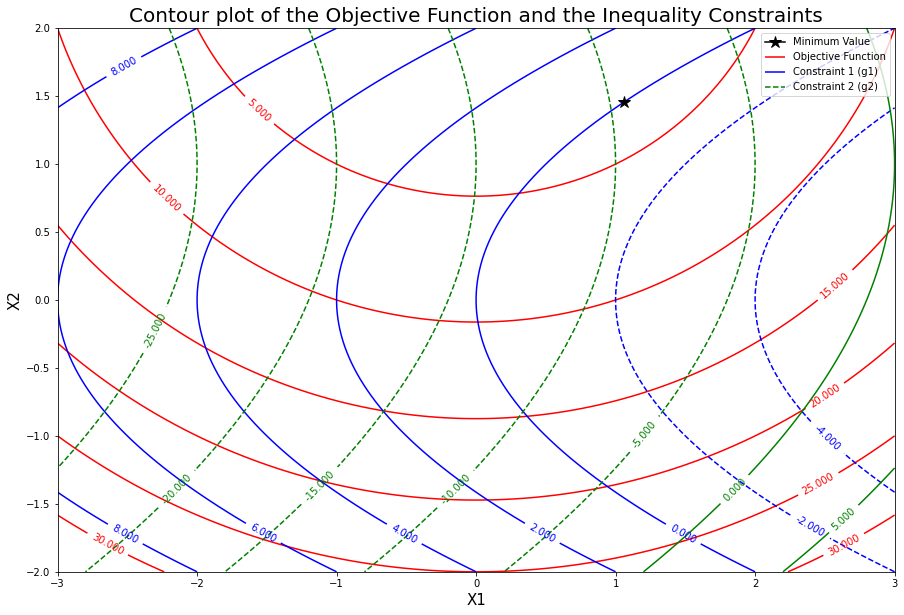

In [34]:
X1 = np.linspace(-3, 3, 100)
X2 = np.linspace(-2, 2, 100)
# cartesian combination of X1 and X2 vectors
param_grid = np.array([[C, x2] for x2 in X2 for C in X1])
real = [objective_function(params) for params in param_grid]
real_g1 = [constraint_g1(params) for params in param_grid]
real_g2 = [constraint_g2(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
fig, ax = plt.subplots(figsize=(15,10))
CS = ax.contour(C, G, np.array(real).reshape(C.shape), colors='r')
ax.clabel(CS, inline=True, fontsize=10)
CS.collections[-1].set_label("Objective Function")

CS1 = ax.contour(C, G, np.array(real_g1).reshape(C.shape), colors='b')
ax.clabel(CS1, inline=True, fontsize=10)
CS1.collections[-1].set_label("Constraint 1 (g1)")

CS2 = ax.contour(C, G, np.array(real_g2).reshape(C.shape), colors='g')
ax.clabel(CS2, inline=True, fontsize=10)
CS2.collections[1].set_label("Constraint 2 (g2)")

plt.plot(x[0], x[1], c='black', marker='*', markersize='12', label='Minimum Value')
ax.legend()
plt.title('Contour plot of the Objective Function and the Inequality Constraints',fontsize = 20)
ax.set_xlabel('X1',fontsize = 15)
ax.set_ylabel('X2',fontsize = 15)
plt.show()

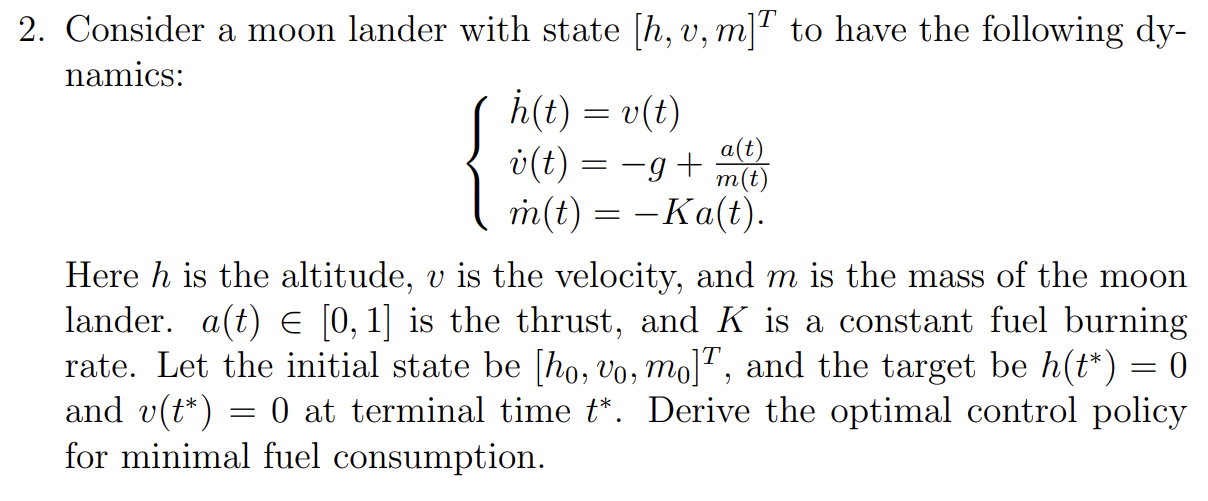

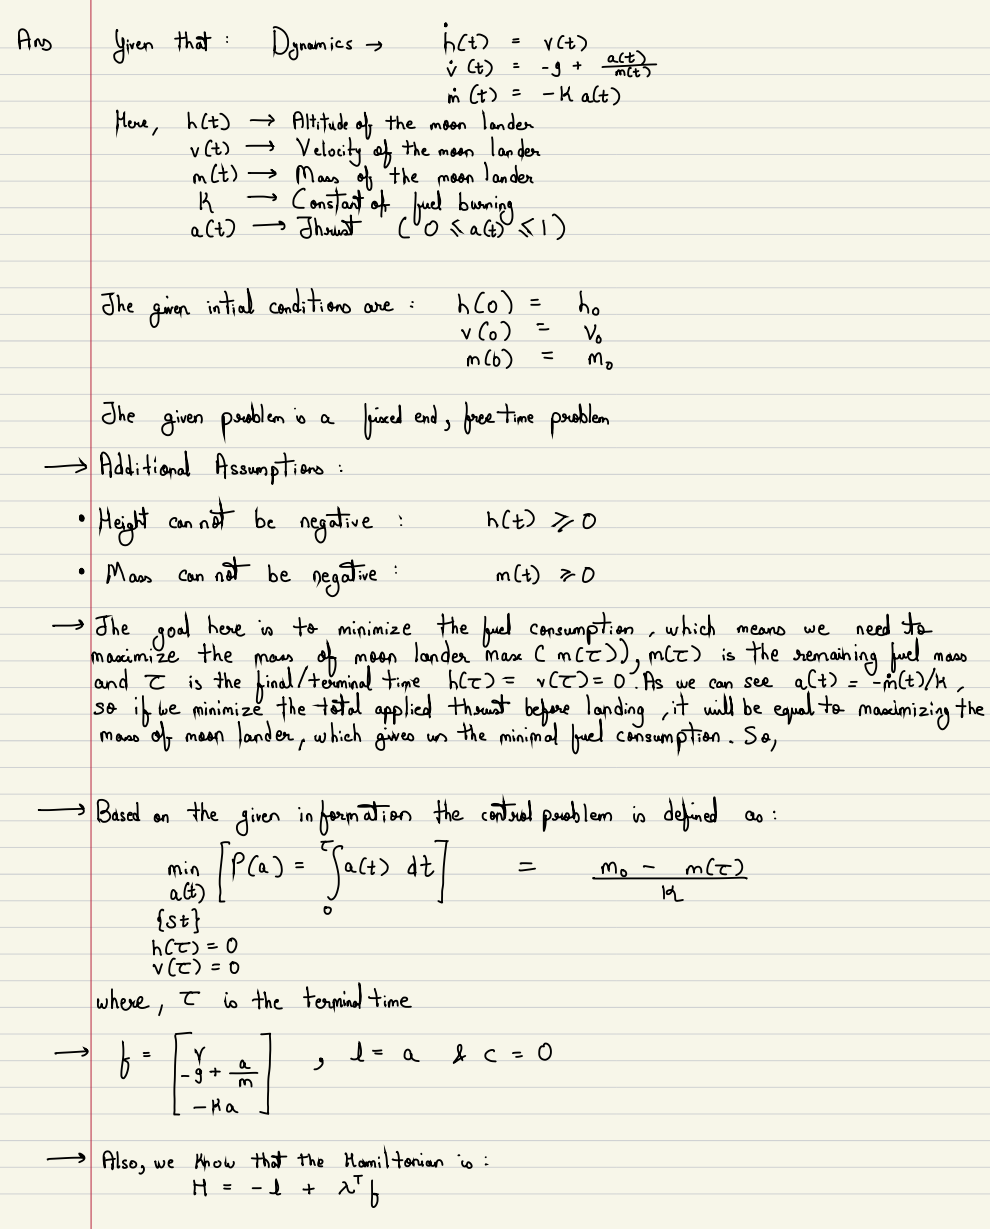

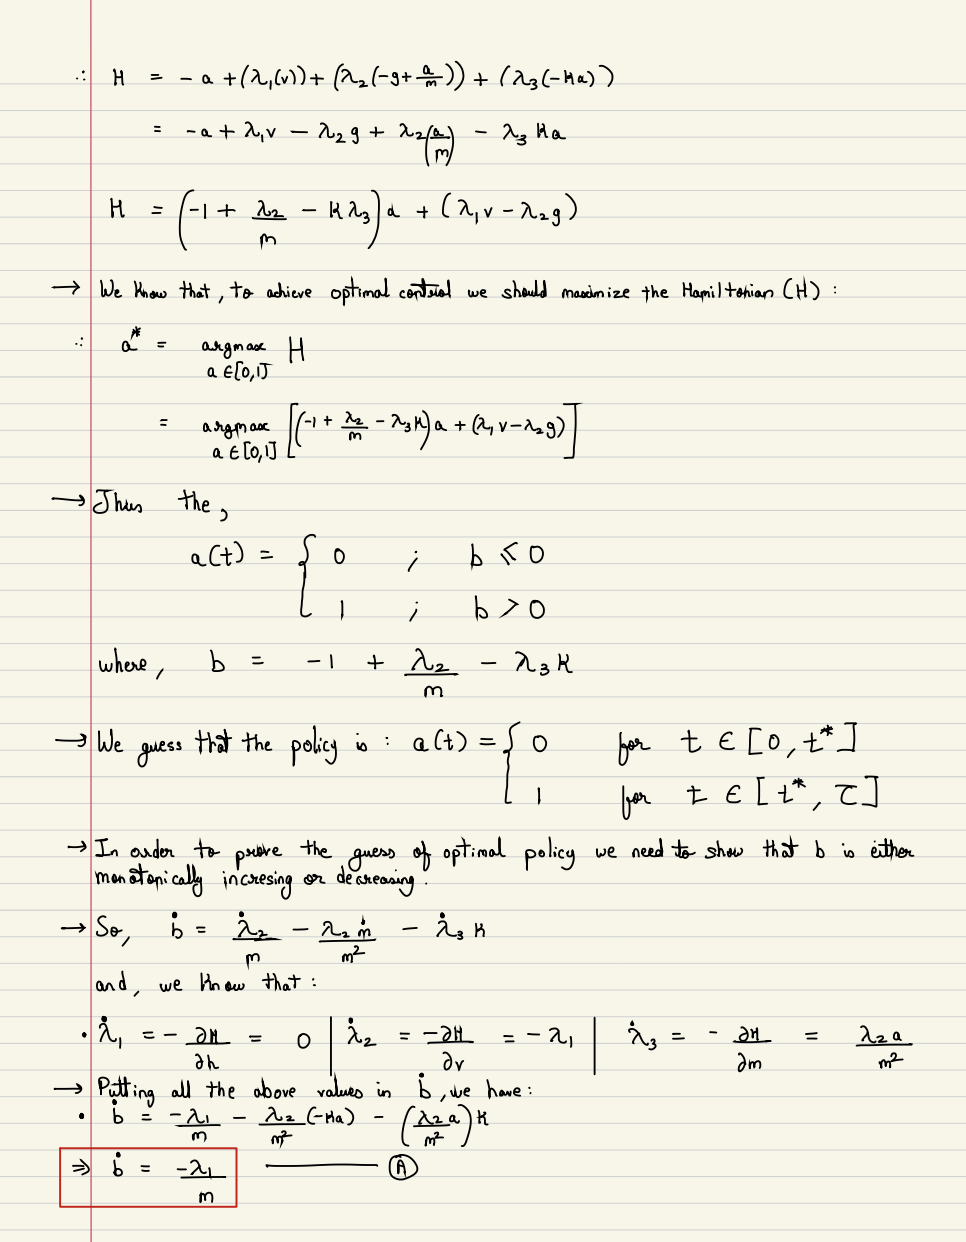

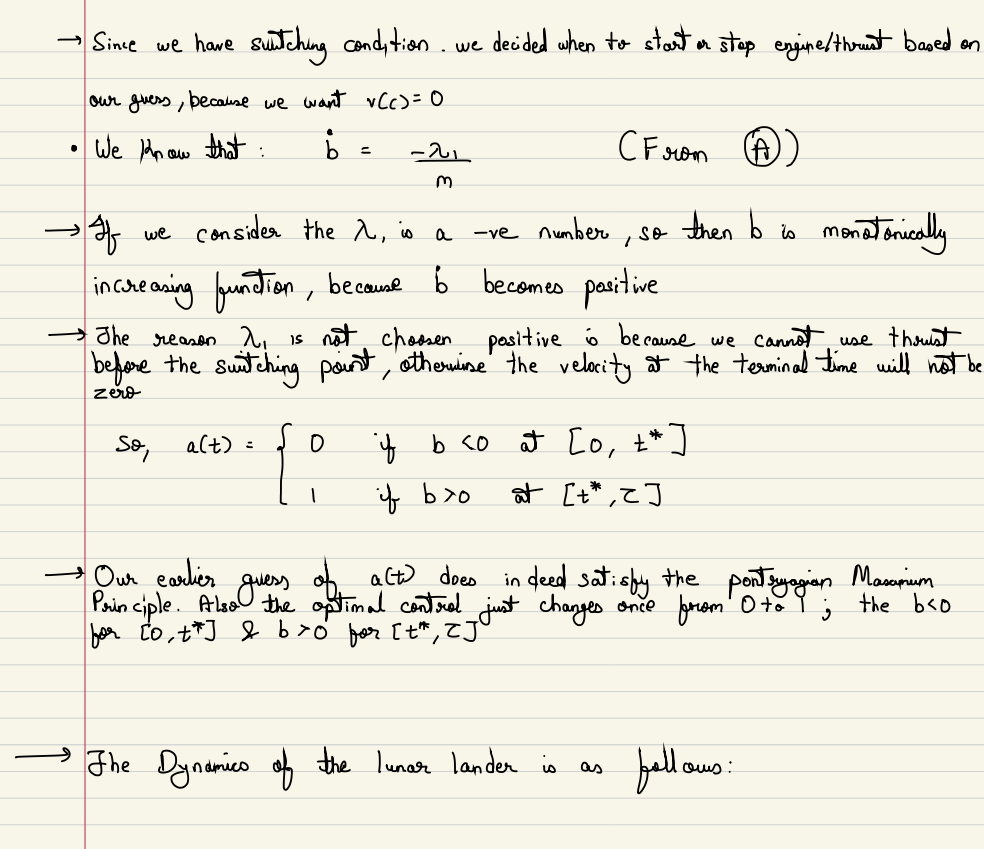

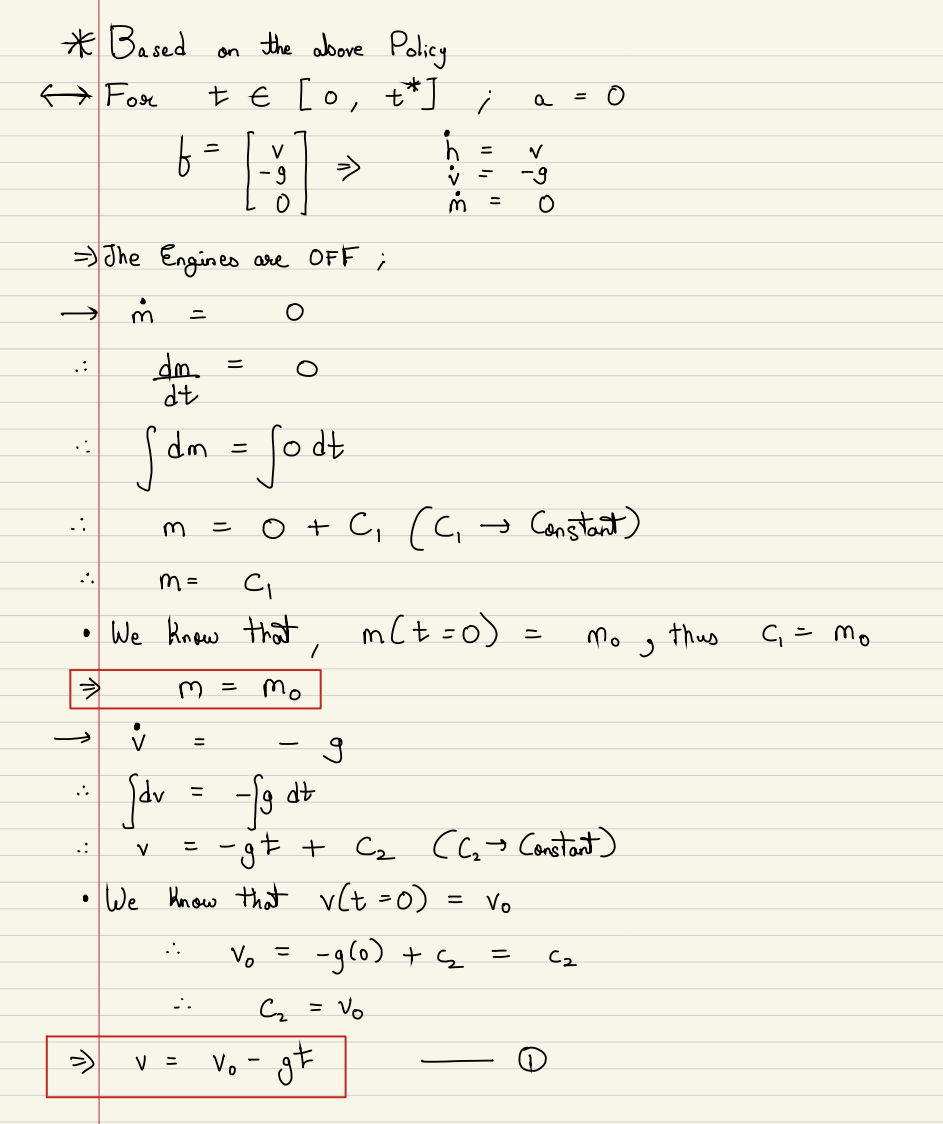

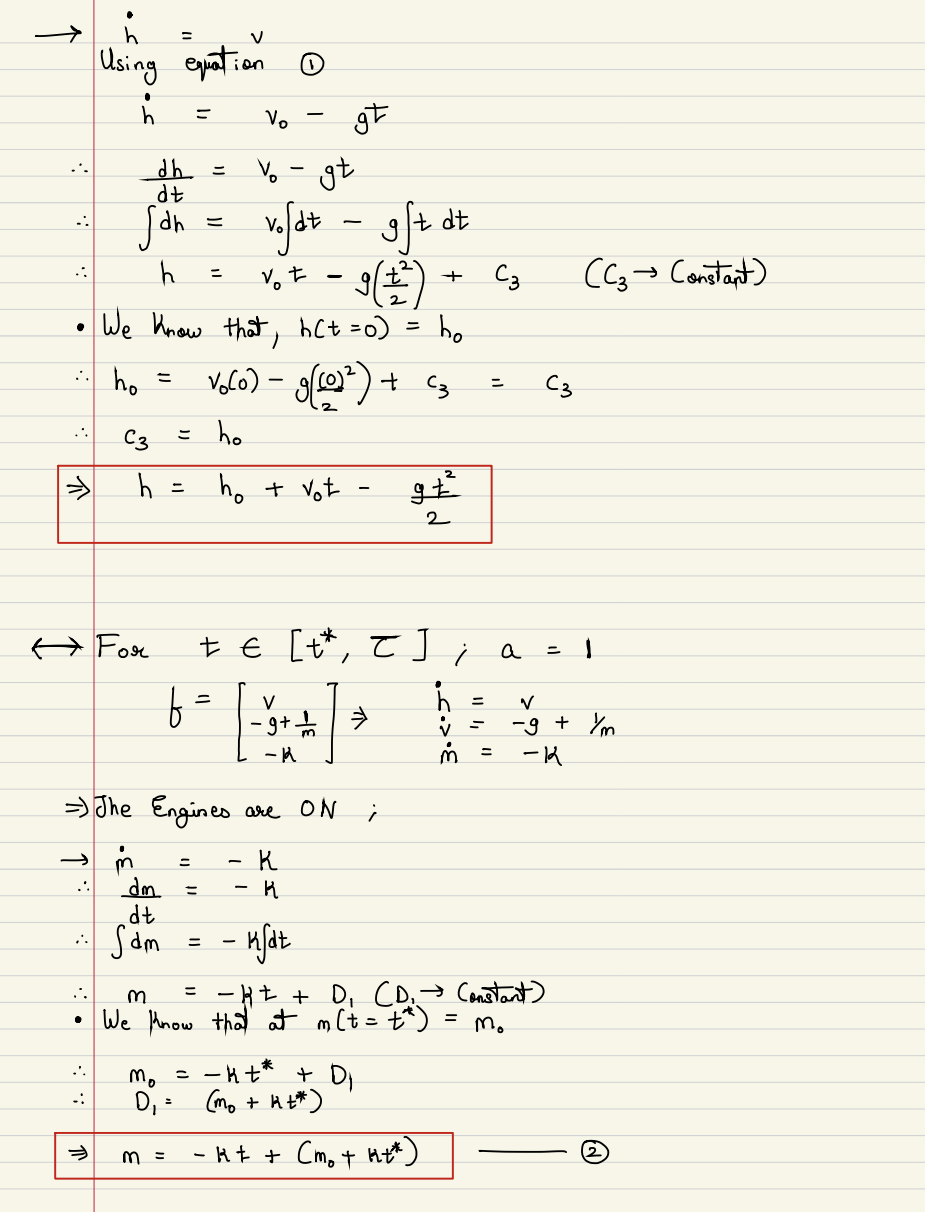

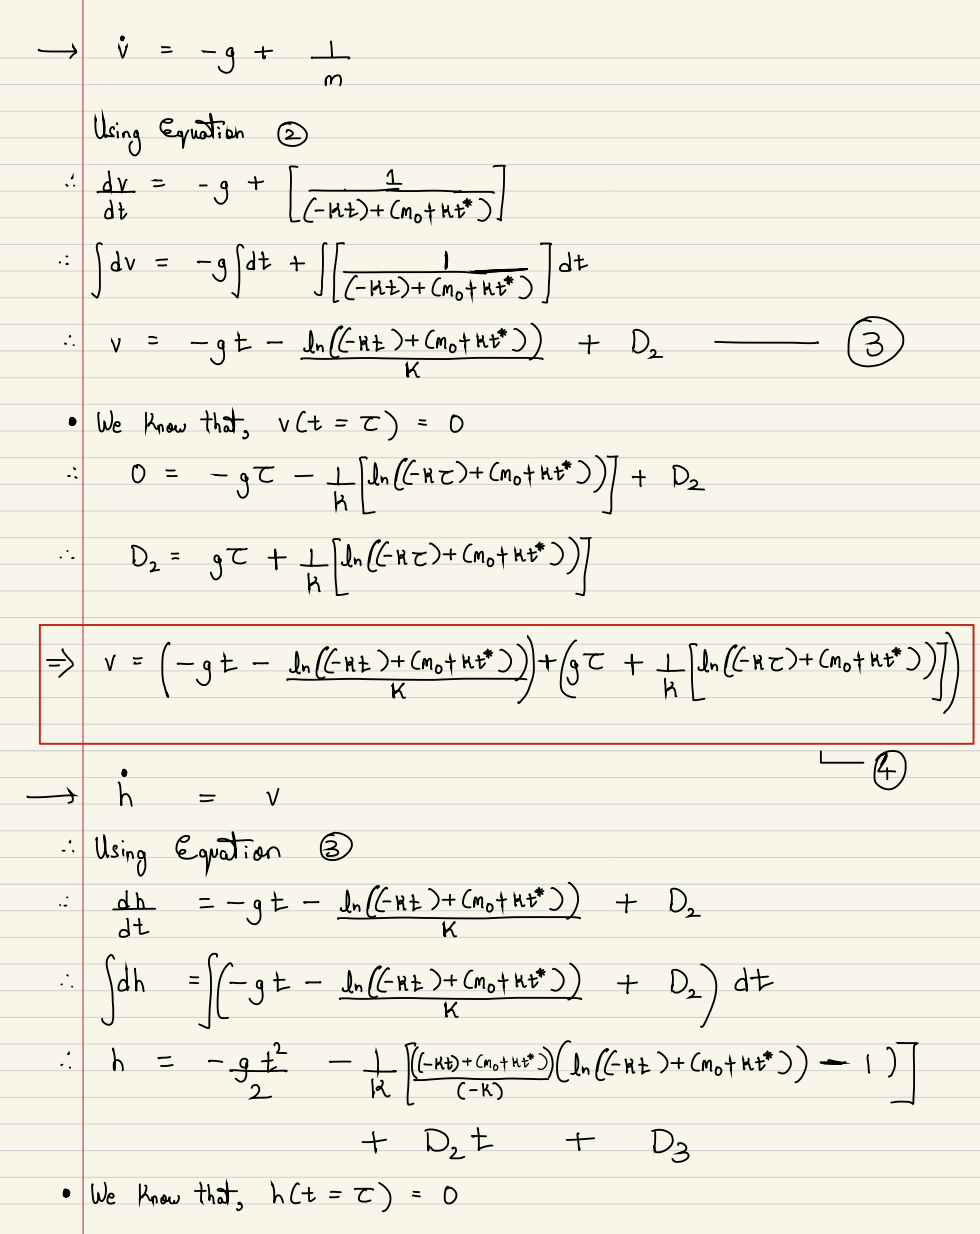

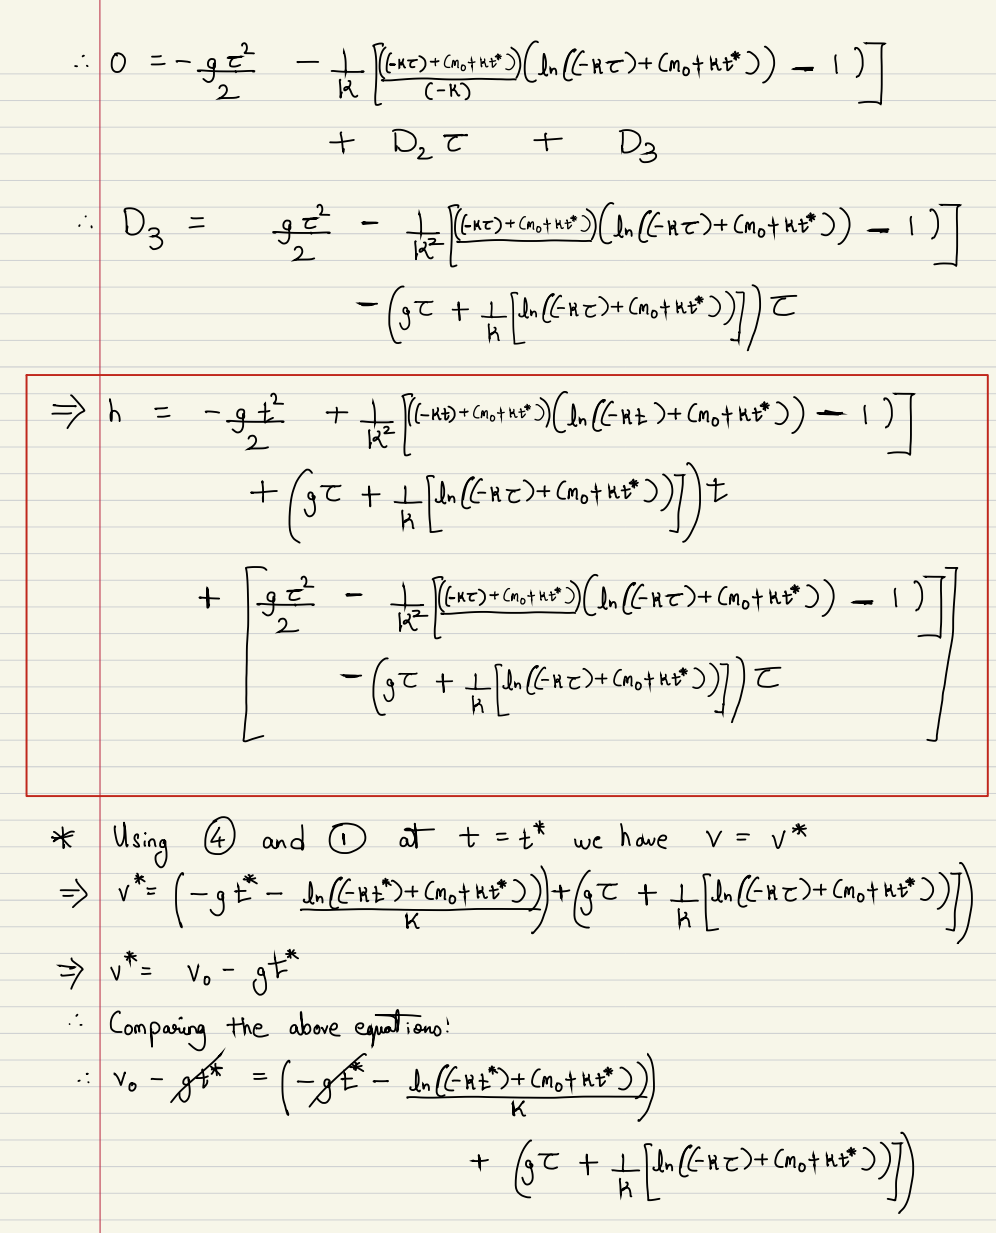

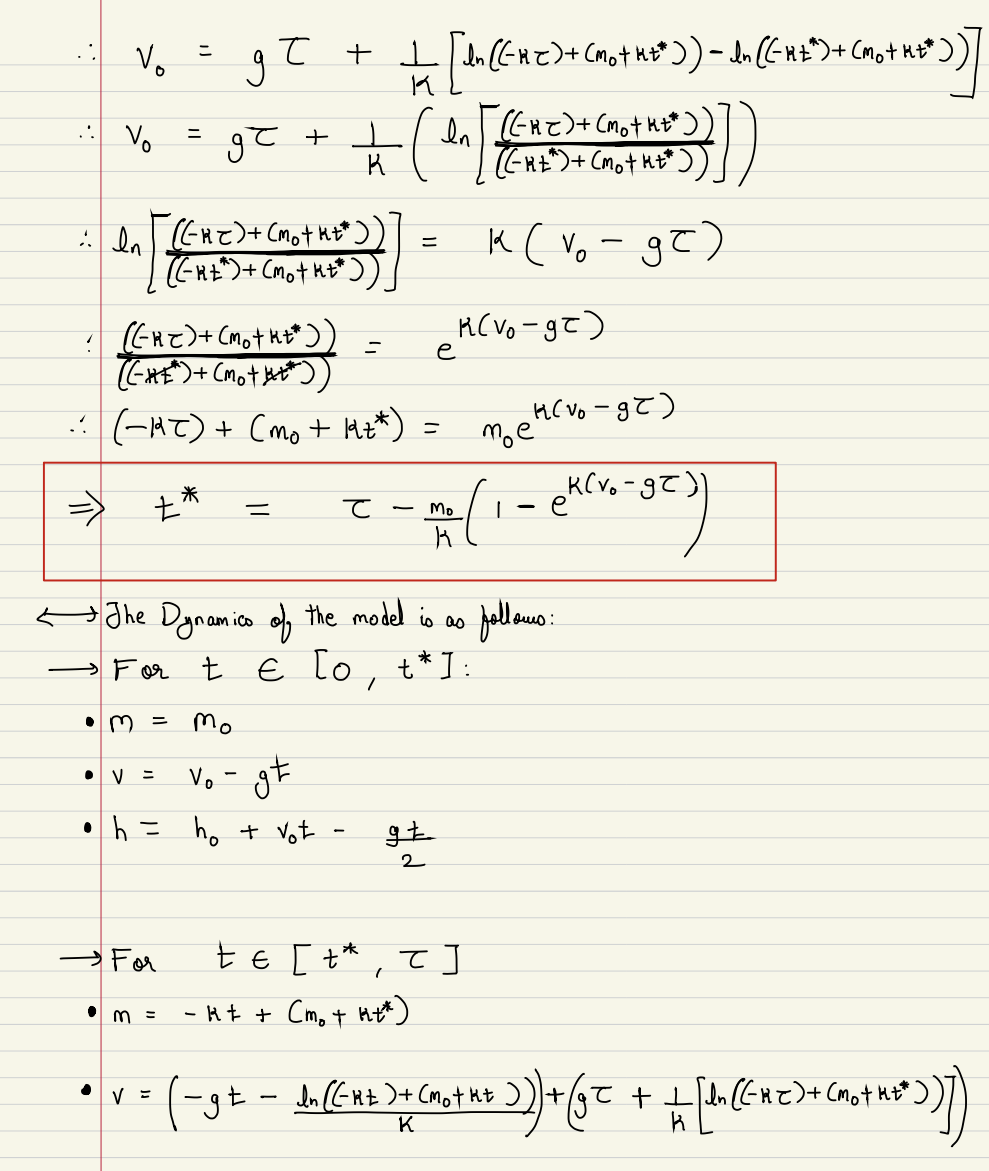

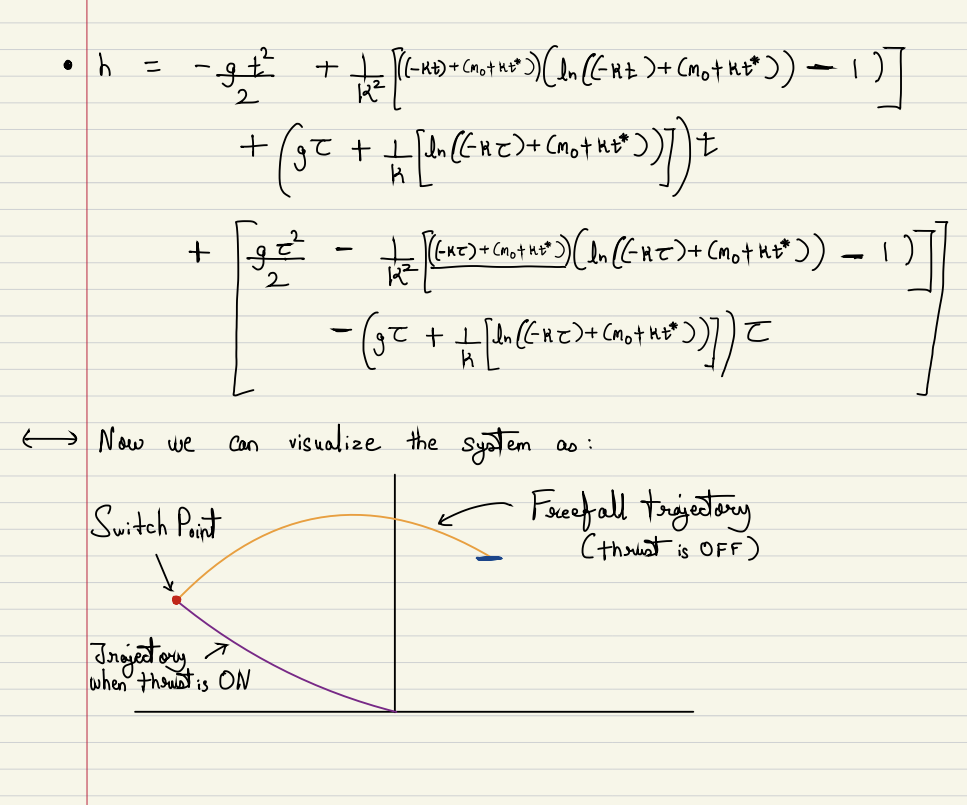